### Bioneuron Oracle Notebook
#### Peter Duggins
#### April 2017
#### https://github.com/psipeter/bionengo/tree/oracle

This notebook includes methods for specifying weights into an emsemble of biologically realistic neurons such that performs representation and dynamics according to the NEF. These 'bioneurons' are implemented in NEURON based off of a reduced model of a pyramidal neuron by Bahl et al (2012). It begins by defining a bioneuron class that includes the NEURON objects needed to track voltage, spikes, etc, as well as the required nengo methods to run in simulation. It then redefines some classes in the nengo builder to allow construction of bioensembles and transmission of spikes to the bioneurons' synapses. During the build, synapses are created at specified locations on the bioneurons' dendrites, and are assigned a synaptic weight that has been decomposed into encoders and decoders. Whereas previous bioneuron methods trained the enoders, this notebook seeks to distribute encoders randomly in a manner that ensures heterogeneity of bioneuron response curves, then trains decoders using NEF methods such as the least-squares solver or Aaron Voelker's Oracle. It then provides tests for the efficacy of these procedures by find the error in the bioensemble's decoded output for various choices of encoder, decoder, and dynamical system.

For now, I'm working in 1 dimension.

### Install NEURON and other dependencies
change --prefix to another directory. If you're using virtualenv and virtualenvwrapper, this will be your your /HOME/USER/.local/directory

```bash
pip install nengo matplotlib seaborn numpy pandas

wget http://www.neuron.yale.edu/ftp/neuron/versions/v7.4/nrn-7.4.tar.gz
tar xzf nrn-7.4.tar.gz
cd nrn-7.4
./configure --prefix=/home/pduggins/.local --without-iv --with-nrnpython
make
(sudo) make install
cd src/nrnpython
python setup.py install
cd ../../..
```

### Install channel mechanisms for the bahl.hoc NEURON model
To run the NEURON model, bahl.hoc, you must download the .hoc file and .mod files for every ion channel present in the model. These can be found in the oracle branch of my bionengo repo. Be sure to change the path to your .local directory to compile the NEURON channel mechanisms. Once this is done, edit the first line of bahl.hoc to point NEURON towards the location of these compiled channel files.

```bash
git clone -b oracle https://github.com/psipeter/bionengo.git
cd bionengo/NEURON_models/
/home/psipeter/.local/x86_64/bin/nrnivmodl

(bahl.hoc, line 1) nrn_load_dll(path/to/NEURON_models/channels)
```

### Define bioneuron class

In [113]:
%matplotlib inline
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import neuron
from nengo.utils.matplotlib import rasterplot

neuron.h.load_file('/home/pduggins/bionengo/NEURON_models/bahl.hoc')

class BahlNeuron(nengo.neurons.NeuronType):
    '''compartmental neuron from Bahl et al 2012'''

    probeable=('spikes','voltage')
    def __init__(self,encoders,syn_locations,weights_bias):
        super(BahlNeuron,self).__init__()
        self.encoders=encoders
        self.syn_locations=syn_locations
        self.weights_bias=weights_bias
        self.inputs={}

    def create(self,bio_idx):
        return self.Bahl(bio_idx,self.encoders[bio_idx],syn_locations[bio_idx],weights_bias[bio_idx])

    class Bahl():
        def __init__(self,bio_idx,encoder,syn_locations,weights_bias):
            self.bio_idx=bio_idx
            self.encoder=encoder             #single encoder for the bioneuron e_j.
            self.syn_locations=syn_locations #locations of synapses on the dendritic tree
            self.weights_bias=weights_bias   #values added to w_ij=dot(d_i,e_j) to account for bias
            self.synapses = {}
            self.netcons = {}
            self.cell = neuron.h.Bahl()
        def start_recording(self):
            '''NEURON recording attributes'''
            self.v_record = neuron.h.Vector()
            self.v_record.record(self.cell.soma(0.5)._ref_v)
            self.ap_counter = neuron.h.APCount(self.cell.soma(0.5))
            self.t_record = neuron.h.Vector()
            self.t_record.record(neuron.h._ref_t)
            self.spikes = neuron.h.Vector()
            self.ap_counter.record(neuron.h.ref(self.spikes))
            self.spikes_last=[]
            
    def rates(self, x, gain, bias): #todo: remove this without errors
        return x

    def gain_bias(self, max_rates, intercepts): #todo: remove this without errors
        return np.ones(len(max_rates)),np.ones(len(max_rates))

    def step_math(self,dt,spiked,neurons,voltage,time):
        '''run NEURON forward one nengo timestep. Compare the current and previous spike arrays
        for this bioneuron. If they're different, the neuron has spiked, so communicate this to nengo'''
        t_neuron=time*1000
        neuron.run(t_neuron) 
        new_spiked=[]
        new_voltage=[]
        for nrn in neurons:
            spike_times=np.array(nrn.spikes)
            spike_times_last=np.array(nrn.spikes_last)
            count=len(spike_times)-len(spike_times_last)
            new_spiked.append(count)
            volt=np.array(nrn.v_record)[-1] #fails if neuron.init() not called at right times
            new_voltage.append(volt)
            nrn.spikes_last=spike_times
        spiked[:]=np.array(new_spiked)/dt
        voltage[:]=np.array(new_voltage)

In [114]:
class ExpSyn():
    '''Conductance-based synapses. There are two types, excitatory and inhibitory, with different
    reversal potentials. If the synaptic weight is above zero, initialize an excitatory synapse, 
    else initialize an inhibitory syanpse with the abolute value of the synaptic weight.'''
    def __init__(self, sec, weight, tau, e_exc=0.0, e_inh=-80.0):
        self.type = 'ExpSyn'
        self.tau = tau
        self.e_exc = e_exc
        self.e_inh = e_inh
        self.syn = neuron.h.ExpSyn(sec)
        self.syn.tau=2*1000*self.tau #arbitrary 2x multiply to offset phase shift in bio decode
        self.weight = weight
        if self.weight >= 0.0: self.syn.e = self.e_exc
        else: self.syn.e = self.e_inh
        self.spike_in = neuron.h.NetCon(None, self.syn) #time of spike arrival assigned in nengo step
        self.spike_in.weight[0]=abs(self.weight)

### Nengo Operators and Builders

In [115]:
from nengo.builder import Builder, Operator, Signal
from nengo.dists import get_samples
from nengo.builder.connection import build_decoders
from nengo.builder.connection import BuiltConnection

class SimBahlNeuron(Operator):
    def __init__(self,neurons,n_neurons,output,voltage,states):
        super(SimBahlNeuron,self).__init__()
        self.neurons=neurons
        self.neurons.father_op=self
        self.output=output
        self.voltage=voltage
        self.time=states[0]
        self.reads = [states[0]]
        self.sets=[output,voltage]
        self.updates=[]
        self.incs=[]
        self.label=None
        self.neurons.neurons=[self.neurons.create(i) for i in range(n_neurons)]
        self.inputs=self.neurons.inputs

    def make_step(self,signals,dt,rng):
        output=signals[self.output]
        voltage=signals[self.voltage]
        time=signals[self.time]
        def step_nrn():
            self.neurons.step_math(dt,output,self.neurons.neurons,voltage,time)
        return step_nrn

    def init_connection(self,inpt):
        '''Given a parcicular connection (labeled by inpt=conn.pre),grab the optimal decoders
        calculated for that connection and the number of presynapic neurons in conn.pre.
        At each location in the specified syn_locations list, create a synapse with weight equal to
        w_ij=np.dot(d_i,e_j)+w_bias, where d_i is the optimal presynaptic decoder, e_j is the single
        bioneuron encoder specified in the encoders list, and w_bias is a weight perturbation that emulates
        the bias in a LIF neuron. Once synapses are created and added to the bioneuron attribute .synapses, 
        initialize the NEURON recording variables and call neuron.init()'''
        for bionrn in range(len(self.neurons.neurons)):
            bioneuron=self.neurons.neurons[bionrn]
            input_decoders=self.inputs[inpt]['input_decoders']
            pre_neurons=input_decoders.shape[0]
            bioneuron.synapses[inpt]=np.empty((pre_neurons,n_syn),dtype=object)
            for pre in range(pre_neurons):
                for syn in range(n_syn):
                    decoder=input_decoders[pre]
                    encoder=bioneuron.encoder #assumes single encoder for bioneuron
                    location=bioneuron.syn_locations[pre][syn]
                    section=bioneuron.cell.apical(location)
                    weight=np.dot(decoder,encoder)
                    weight+=bioneuron.weights_bias[pre]
                    synapse=ExpSyn(section,weight,tau)
                    bioneuron.synapses[inpt][pre][syn]=synapse            
            bioneuron.start_recording() #todo - call elsewhere so it's not redundant
        neuron.init()


In [116]:
class TransmitSpikes(Operator):
    '''Operator to deliver (unweighted) spikes from the presynaptic population into a bioensemble'''
    def __init__(self,ens_pre_label,spikes,bahl_op,states):
        self.ens_pre_label=ens_pre_label
        self.spikes=spikes
        self.bahl_op=bahl_op
        self.neurons=bahl_op.neurons.neurons
        self.time=states[0]
        self.reads=[spikes,states[0]]
        self.updates=[]
        self.sets=[]
        self.incs=[]
    def make_step(self,signals,dt,rng):
        spikes=signals[self.spikes]
        time=signals[self.time]
        def step():
            'event-based method'
            tback=time-dt
            t_neuron=tback*1000
            for n in range(spikes.shape[0]): #for each input neuron
                my_spikes=spikes[n] #actual spikes
                if my_spikes > 0: #if input neuron spiked
                    for nrn in self.neurons: #for each bioneuron
                        for syn in nrn.synapses[self.ens_pre_label][n]: #for each synapse conn. to input
                            syn.spike_in.event(t_neuron) #add a spike at time (ms)
        return step

In [117]:
@Builder.register(BahlNeuron)
def build_bahlneuron(model,neuron_type,ens):
    model.sig[ens]['voltage'] = Signal(np.zeros(ens.ensemble.n_neurons),
                        name='%s.voltage' %ens.ensemble.label)
    op=SimBahlNeuron(neurons=neuron_type,
                     n_neurons=ens.ensemble.n_neurons,
                     output=model.sig[ens]['out'],
                     voltage=model.sig[ens]['voltage'],
                     states=[model.time])
    model.add_op(op)

@Builder.register(nengo.Ensemble)
def build_ensemble(model,ens):
    nengo.builder.ensemble.build_ensemble(model,ens)

@Builder.register(nengo.Connection)
def build_connection(model,conn):
    '''Method to build connections into bioensembles.
    Calculates the optimal decoders for this conneciton as though the presynaptic neuron 
    was connecting to a hypothetical point neuron. These decoders are used to calculate
    the synaptic weights in init_connection().
    Adds a transmit_spike operator for this connection to the model
    '''
    use_nrn = (
        isinstance(conn.post, nengo.Ensemble) and
        isinstance(conn.post.neuron_type, BahlNeuron))
    if use_nrn: #bioneuron connection
        rng = np.random.RandomState(model.seeds[conn])
        model.sig[conn]['in']=model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out, d=conn.size_mid, rng=rng)
        eval_points, weights, solver_info = build_decoders(model, conn, rng, transform)
        op=conn.post.neuron_type.father_op
        op.label=conn.post.label
        op.inputs[conn.pre.label]={'input_decoders':weights.T} #will stop working for bio-bio connections
        op.init_connection(conn.pre.label)
        model.add_op(
            TransmitSpikes(conn.pre_obj.label,model.sig[conn.pre]['out'],op,states=[model.time]))
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                             solver_info=solver_info,
                                             transform=transform,
                                             weights=weights)

    else: #normal connection
        return nengo.builder.connection.build_connection(model, conn)

### Helper Functions

In [118]:
from nengo.builder.ensemble import get_activities
def decode_bias(bias, activity):
    '''
    From Andreas Stockel 
    Emulate biases by decoding them separately off the LIF population and adding it to the resulting connection weights
    https://github.com/ctn-waterloo/nengo_conductance_synapses/blob/master/ifcondexp.ipynb
    '''
    
    A = activity # Fetch theactivity matrix
    m, n = A.shape  # samples, neurons
    Y = np.tile(bias, (m, 1))  # Desired output function Y -- just repeat "bias" m times
    I = np.eye(n) * ((np.max(A) * 0.1)**2) # Regularisation matrix
    # Calculate the decoders using a least squares estimate
    return (np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)/m + I),A.T),Y).T) / m

def pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed):
    '''Build a pre-simulation network to draw encoders, gains, and biases from Nengo,
    scale them, and return a weight matrix that emulates the bias
    (by adding weights to the synaptic weights in init_connection()'''
    
    with nengo.Network(label='preliminary') as pre_model:
        stim = nengo.Node(lambda t: np.sin(t))
        pre=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,label='pre',seed=pre_seed)
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif',seed=bio_seed)
        post=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,seed=9,label='post')
        conn_stim_to_pre=nengo.Connection(stim,pre,synapse=None)
        conn_pre_to_lif=nengo.Connection(pre,lif,synapse=tau)
        conn_lif_to_post=nengo.Connection(lif,post,synapse=tau)
    with nengo.Simulator(pre_model,dt=dt) as pre_sim:
        pre_activities = get_activities(pre_sim.data[pre], pre, pre_sim.data[pre].eval_points)
        lif_encoders=pre_sim.data[lif].encoders
        pre_decoders=pre_sim.data[conn_pre_to_lif].weights.T
        lif_biases=pre_sim.data[lif].bias
        lif_gains=pre_sim.data[lif].gain
        lif_decoders=pre_sim.data[conn_lif_to_post].weights.T
    weights_bias = decode_bias(lif_biases,pre_activities)
    return lif_encoders, lif_gains, weights_bias

def delete_bioneurons(bioensemble):
    '''NEURON garbage collection, so that successive model initializations don't accumulate NEURON objects'''
    for bioneuron in bioensemble.neuron_type.father_op.neurons.neurons:
        del bioneuron

### Simulation and Plotting

In [119]:
def simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,
             pre_seed,bio_seed,decoders_bio=None,to_plot='all'):
    '''
    Simulate a feedforward network [stim]-[LIF]-[BIO], and compare to [stim]-[LIF]-[LIF].
    lif_encoders: encoders for bioneurons calculated for a hypothetical LIF population in pre_model()
    weights_bias: weight additions that emulate the bias for a hypothetical LIF population in pre_model()
    bio_seed: ensemble seed for bioensemble
    pre_seed: ensemble seed for lif emsemble
    decoders_bio: use the output decoders for [BIO]-[probe] from a previous simulation rather than
                    calculating them again using nengo.solver.LstsqL2()
    '''
    with nengo.Network() as model:
        stim = nengo.Node(lambda t: np.sin(2*np.pi*t))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(lif_encoders,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)
        
    '''make sick plotz'''
    sns.set(context='poster')

    if to_plot == 'all' or to_plot == 'spikes':
        '''spike raster for PRE, BIO and comparison LIF ensembles'''
        figure, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
        rasterplot(sim.trange(),sim.data[probe_pre_spikes],ax=ax1,use_eventplot=True)
        ax1.set(ylabel='pre',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if to_plot == 'all' or to_plot == 'voltage':
        '''voltage trace for a specific bioneuron'''
        figure2,ax3=plt.subplots(1,1,sharex=True)
        bio_idx=0
        neuron=bio.neuron_type.father_op.neurons.neurons[bio_idx]
        ax3.plot(dt*np.arange(0,len(np.array(neuron.v_record))),np.array(neuron.v_record))
        ax3.set(xlabel='time (ms)', ylabel='Voltage (mV)')

    if to_plot == 'all' or to_plot == 'decode':
        '''decoded output of bioensemble'''
        figure3,ax4=plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        if decoders_bio==None:
            decoders_bio, info = solver(
                                    lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                                    lpf.filt(sim.data[probe_pre], dt=dt)) #one filter on target
                                    # lpf.filt(lpf.filt(sim.data[probe_pre], dt=P['dt_nengo']), dt=P['dt_nengo']))
        xhat_bio=np.sum(lpf.filt(sim.data[probe_bio_spikes], dt=dt)*decoders_bio.ravel(),axis=1)
        rmse_bio=np.sqrt(np.average((sim.data[probe_direct].ravel()-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    
    delete_bioneurons(bio)
    return decoders_bio

# Experiments

In [40]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=1.0
pre_seed=3
bio_seed=6

'''identical synaptic locations for each neuron'''
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])
# syn_locations=rng.uniform(0,1,size=(n_neurons,pre_neurons,n_syn))

Simplest setup - single encoder per neuron, one synapse, gains and biases not accounted for, synaptic locations identical for every bioneuron (still a unique location for every synapse on the dendrite)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:31.                                                 


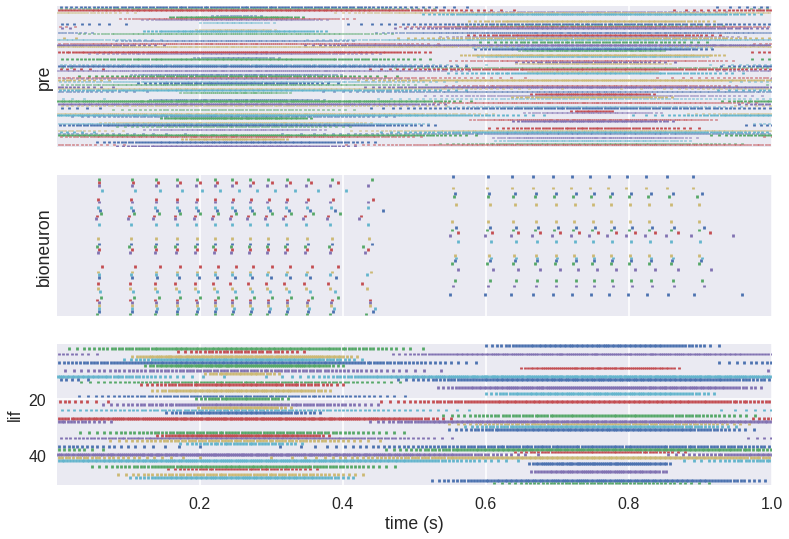

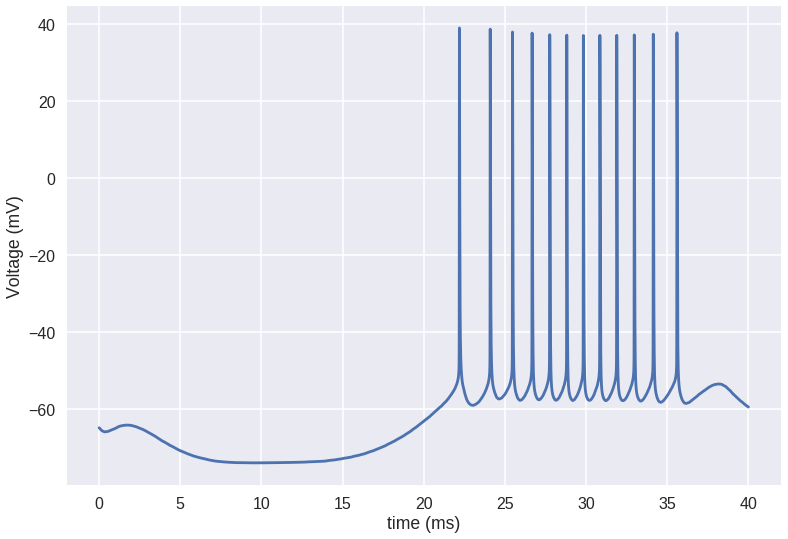

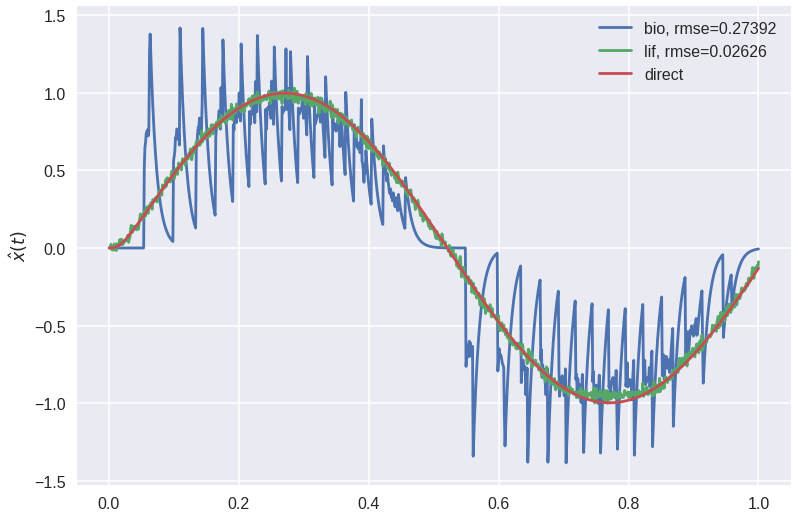

In [41]:
lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

'''gains and biases are ignored'''
weights_bias=np.zeros((weights_bias.shape))
# lif_encoders *= lif_gains.reshape(-1, 1)

'''save decoders for [BIO]-[probe] for later'''
decoders_bio_1=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed)

gains multiply encoders, bias still set to zero. A lot of the benefit here comes just from scaling the encoders, but presumably making them more heterogeneous also helps

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:31.                                                 


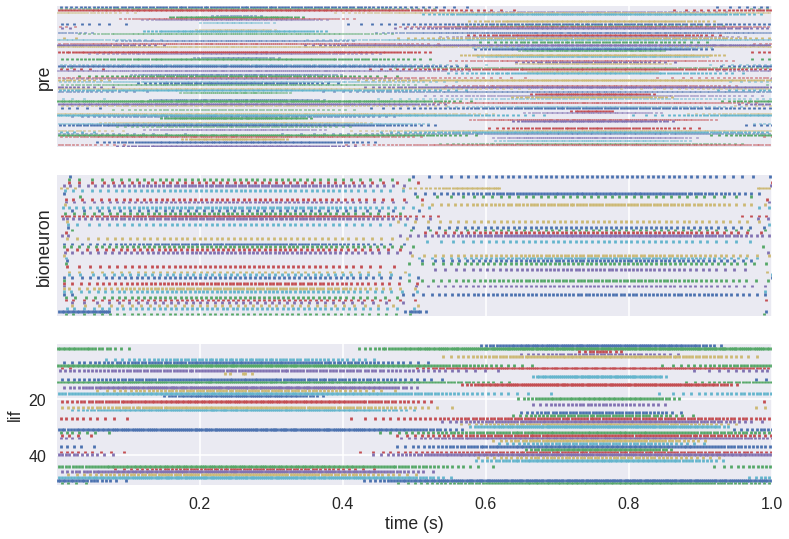

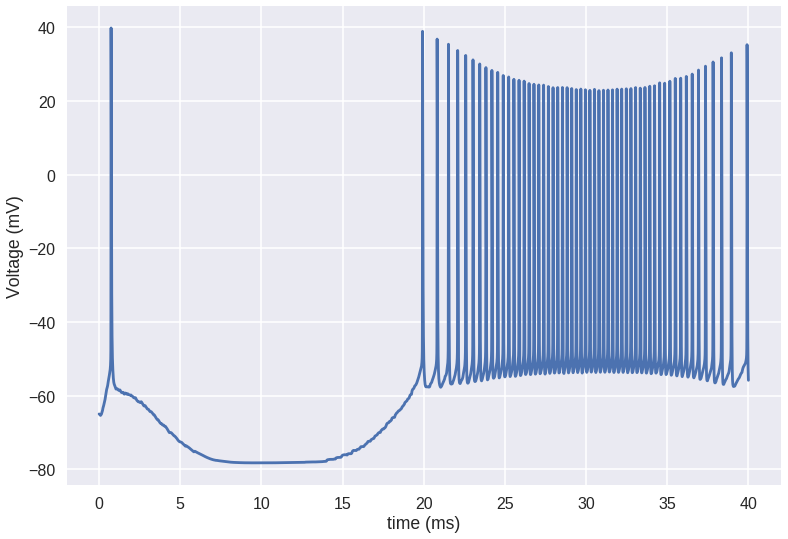

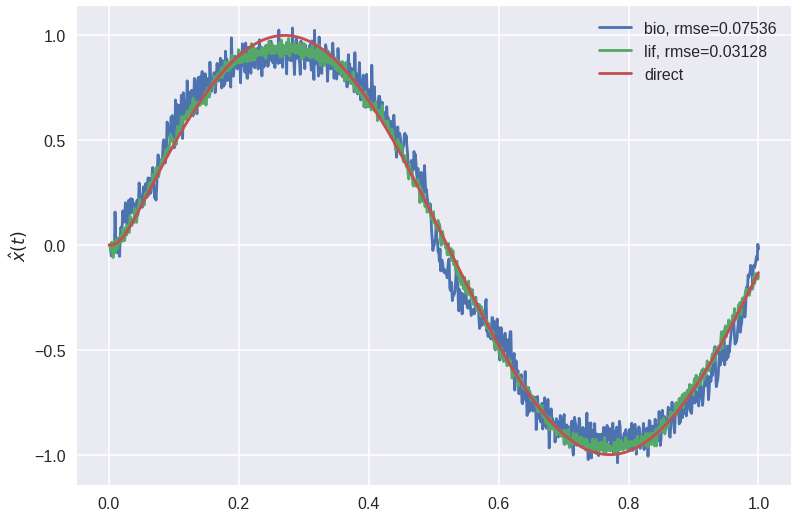

In [42]:
lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

weights_bias=np.zeros((weights_bias.shape))
lif_encoders *= lif_gains.reshape(-1, 1)

decoders_bio_2=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed)

gains multiply encoders and weights account for bias

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:01.                                                 


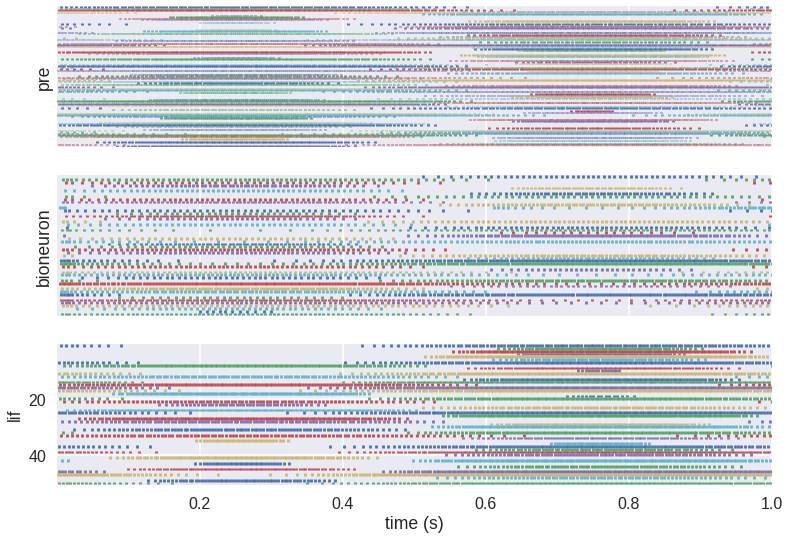

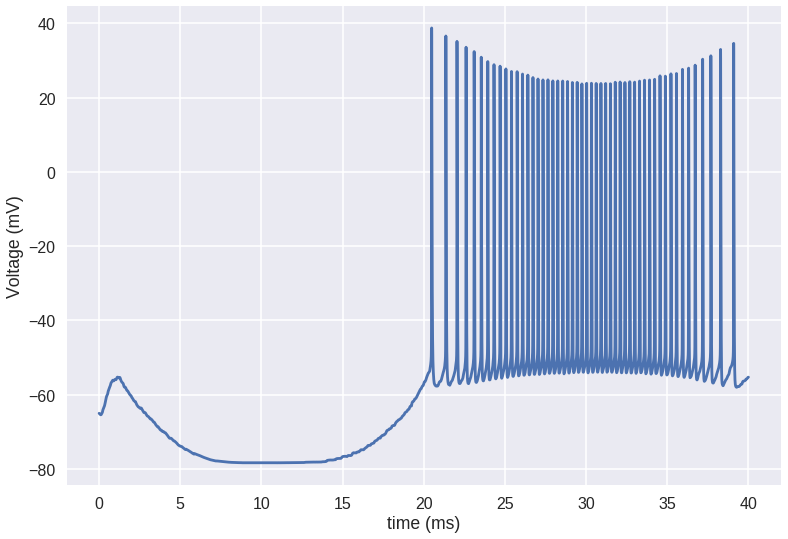

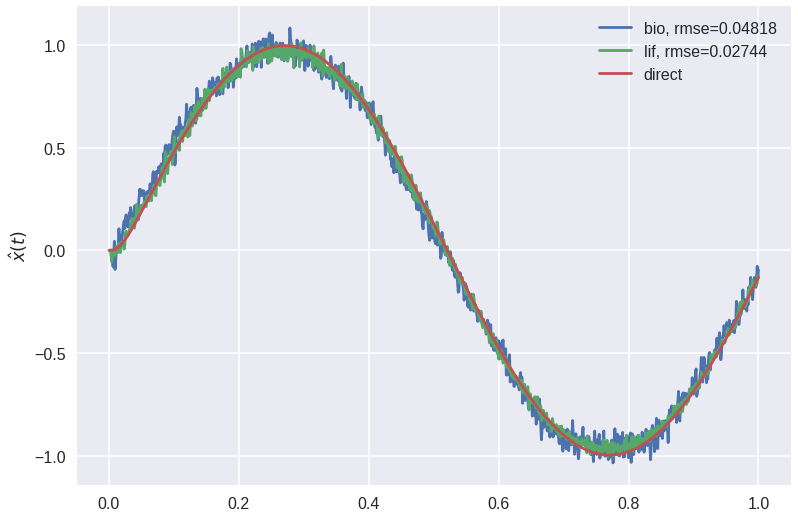

In [43]:
lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

lif_encoders *= lif_gains.reshape(-1, 1)

decoders_bio_3=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed)

Now repeat the last experiment (using gains and biases), but with a new pre_seed and and either random decoders or the old decoders

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:01.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


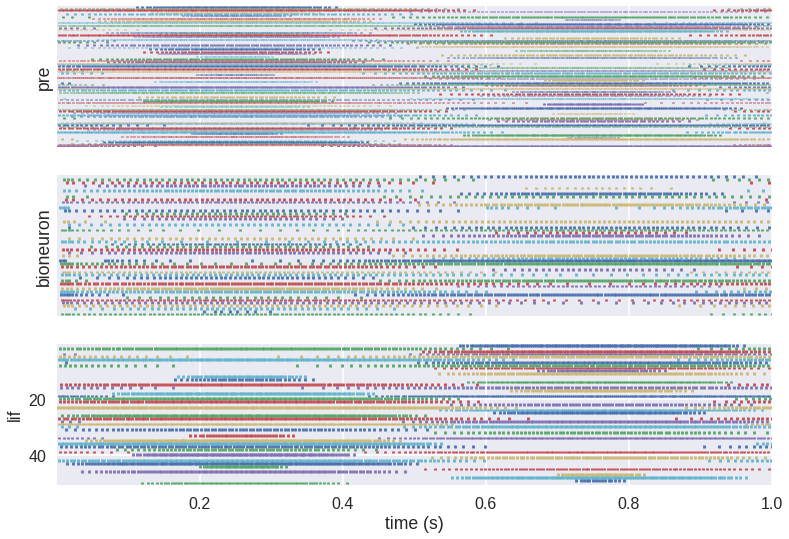

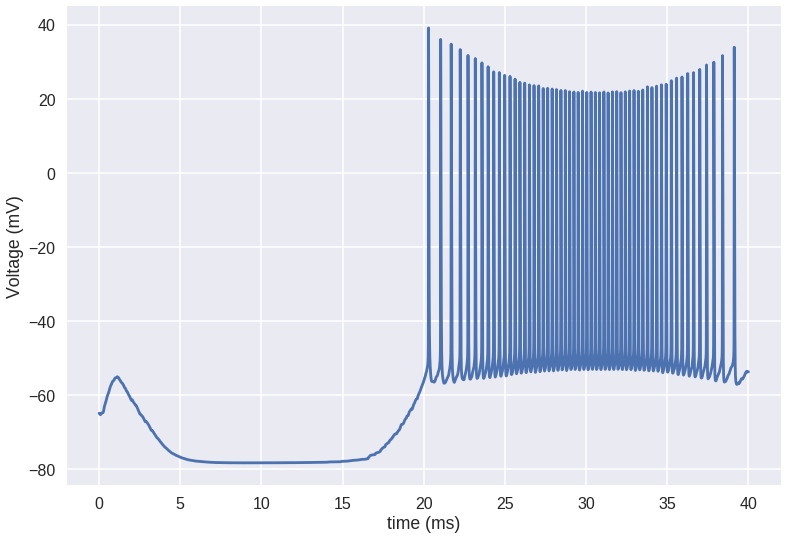

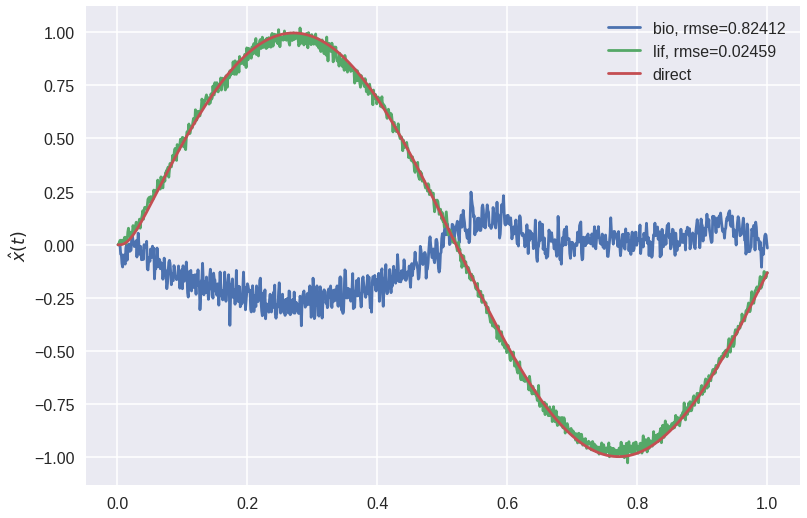

In [44]:
pre_seed=1

lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

lif_encoders *= lif_gains.reshape(-1, 1)

random_decoders=rng.uniform(np.min(decoders_bio_3),np.max(decoders_bio_3),size=decoders_bio_3.shape)
decoders_bio_4=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed,random_decoders)

# decoders_bio_6=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed,decoders_bio_3)

Random decoders aren't great, but at least they preserve the shape.

Now let's try loading the previously computed decoders.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:59.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


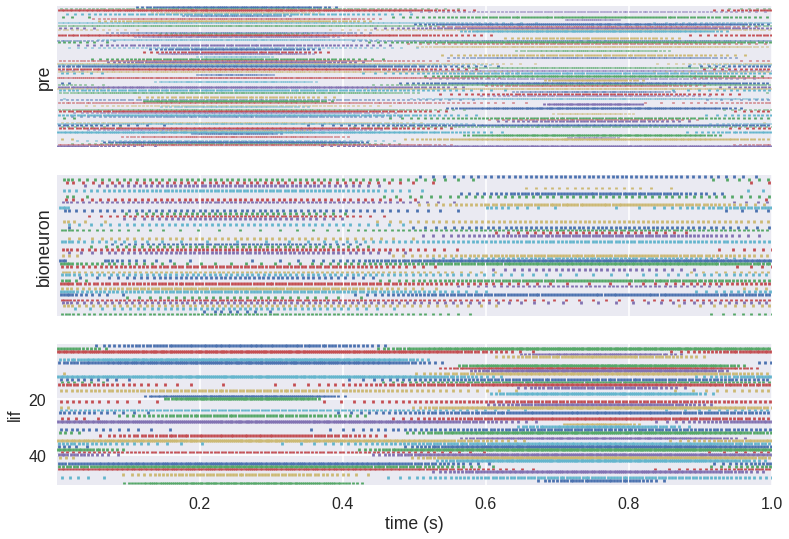

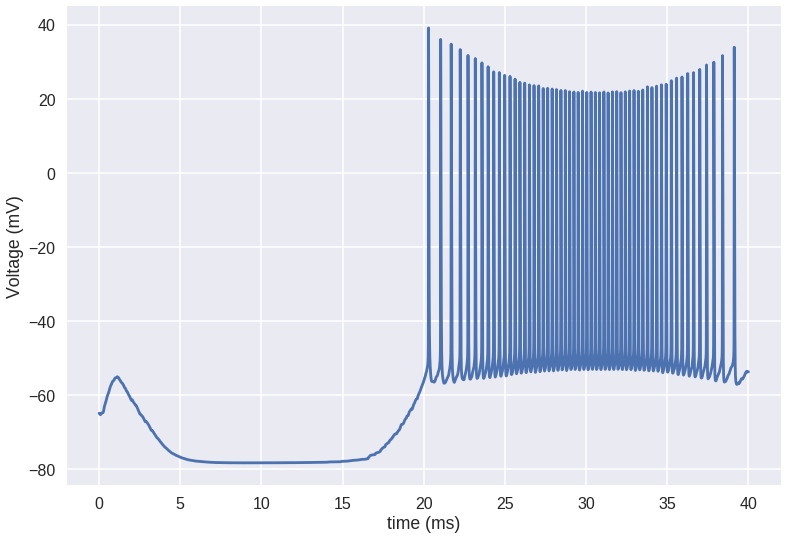

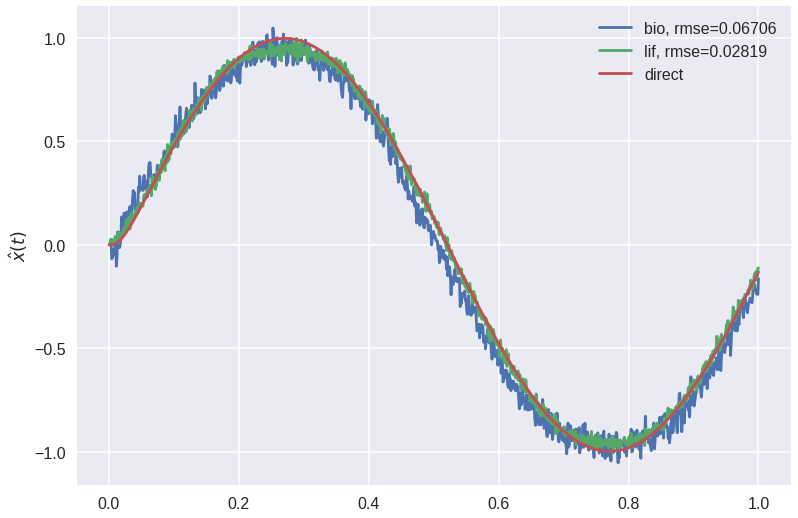

In [45]:
lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

lif_encoders *= lif_gains.reshape(-1, 1)

decoders_bio_5=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed,decoders_bio_3)

Very accurate decoding! This is promising evidence for the idea that the bioneuron responses might be identical for similar state-space inputs, even if the presynaptic spike trains are different.

As a quick check, use an old weight-bias to make sure that decode_bias() isn't abusing its knowledge of pre_activity. 

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:00.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


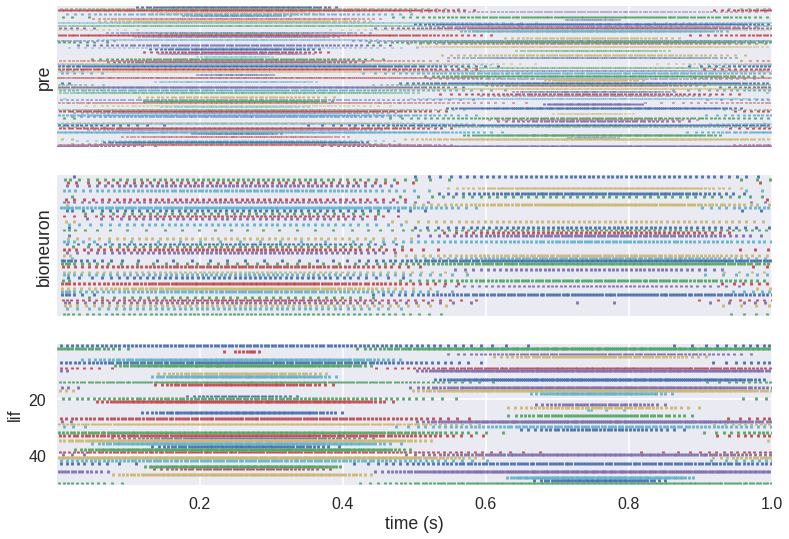

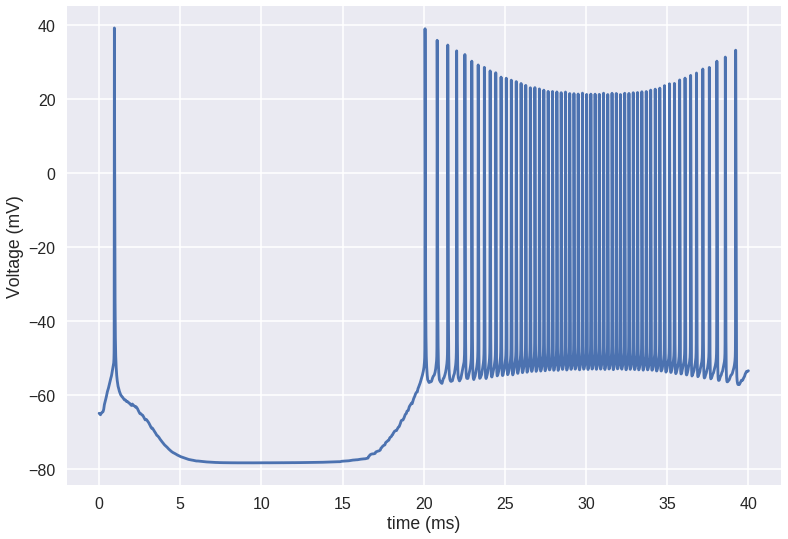

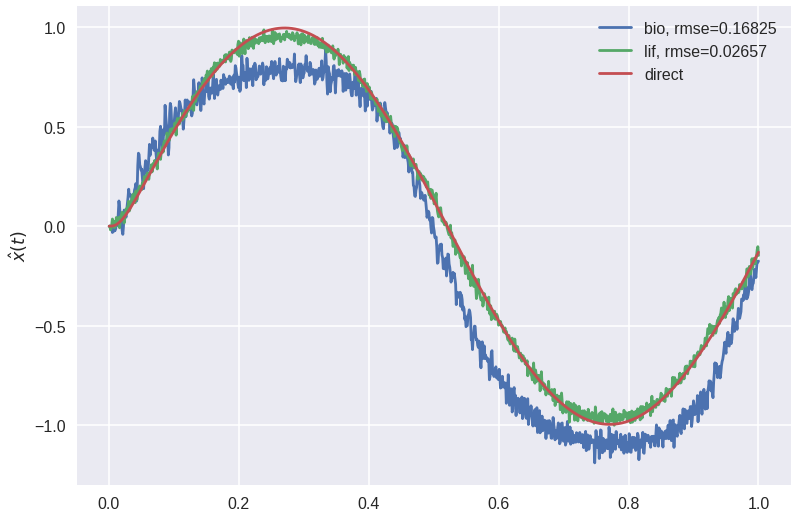

In [46]:
pre_seed=3
lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)
lif_encoders *= lif_gains.reshape(-1, 1)

pre_seed=1
decoders_bio_5=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed,decoders_bio_3)

### Response Curve Unit Test

In [142]:
def response_curve_unit_test(x_vals,t_per_x,n_neurons,tau,dim,n_syn,dt,
                             lif_encoders,syn_locations,weights_bias,
                             pre_seed,bio_seed,decoders_bio=None,to_plot='response_curve'):
    
    with nengo.Network() as model:
        stim = nengo.Node(lambda t: x_vals[int((t-dt)/t_per_x)])
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(lif_encoders,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_per_x*x_vals.shape[0])
        
    lpf=nengo.Lowpass(tau)
    columns=('x','t','bionrn','rate')
    df=pd.DataFrame(columns=columns,index=np.arange(0,n_neurons*x_vals.shape[0]*int(t_per_x/dt)))
    df_lif=pd.DataFrame(columns=columns,index=np.arange(0,n_neurons*x_vals.shape[0]*int(t_per_x/dt)))
    delta_rates=np.zeros((n_neurons))
    j=0
    for bionrn in range(n_neurons):
        spikes=sim.data[probe_bio_spikes][:,bionrn]
        spikes_lif=sim.data[probe_lif_spikes][:,bionrn]
        rates=lpf.filt(spikes,dt=dt)
        rates_lif=lpf.filt(spikes_lif,dt=dt)
        rates_per_x=np.array([rates[i*int(t_per_x/dt):(i+1)*int(t_per_x/dt)] for i in range(len(x_vals))])
        rates_per_x_lif=np.array([rates_lif[i*int(t_per_x/dt):(i+1)*int(t_per_x/dt)] for i in range(len(x_vals))])
        for x in range(rates_per_x.shape[0]):
            for t in range(rates_per_x.shape[1]):
                df.loc[j]=[x_vals[x],t,bionrn,rates_per_x[x,t]]
                df_lif.loc[j]=[x_vals[x],t,bionrn,rates_per_x_lif[x,t]]
                j+=1
        min_rate=np.min(np.mean(rates_per_x,axis=1))
        max_rate=np.max(np.mean(rates_per_x,axis=1))
        delta_rates[bionrn]=max_rate-min_rate
                
    if to_plot == 'response_curve':
        sns.set(context='poster')
#         figure3,ax3=plt.subplots(1,1)
#         ax3.plot(sim.trange(),sim.data[probe_stim])
#         ax3.set(ylabel='stim')
        figure2,ax2=plt.subplots(1,1)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        figure1,ax1=plt.subplots(1,1)
        sns.tsplot(time="x",value="rate",unit='t',condition='bionrn',data=df)
        ax1.set(xlabel='x',ylabel='BIO firing rate (hz)')
#         figure4,ax4=plt.subplots(1,1)
#         sns.tsplot(time="x",value="rate",unit='t',condition='bionrn',data=df_lif)
#         ax4.set(xlabel='x',ylabel='LIF firing rate (hz)')
    return np.array(delta_rates)

While there are bioneurons whose min and max rate (in response to step inputs ranging from x_min to x_max) differ by less than the delta_rates_threshold, keep choosing new encoders and weights_bias for those neurons.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:08:50.                                                 
[ 143.01360991  210.57134286  131.26500709  173.53986277  149.23341856
  160.43340648  179.95763588  122.39775281  162.64447306  249.37016443
  130.91140001  297.63315267  141.00184033  101.76426678  277.40193018
  118.21179961  165.00051821  144.29130018  155.95211697  108.51090572
   90.18166881  148.71625187  131.41953381  108.69989675  166.67703146
  139.7714792   219.22611333  166.82708655  208.64090176  186.60273256
   91.75238181    6.          184.21181208  152.06264552  210.02221412
  217.39938912  129.36061083   99.55265633  298.92236361  140.02558721
  296.0009502   281.69114407   39.63405804   91.40068049  273.45424933
  185.82493106  184.81514087  127.12396969    0.          230.90245855] 1
Building finished in 0:00:01.               

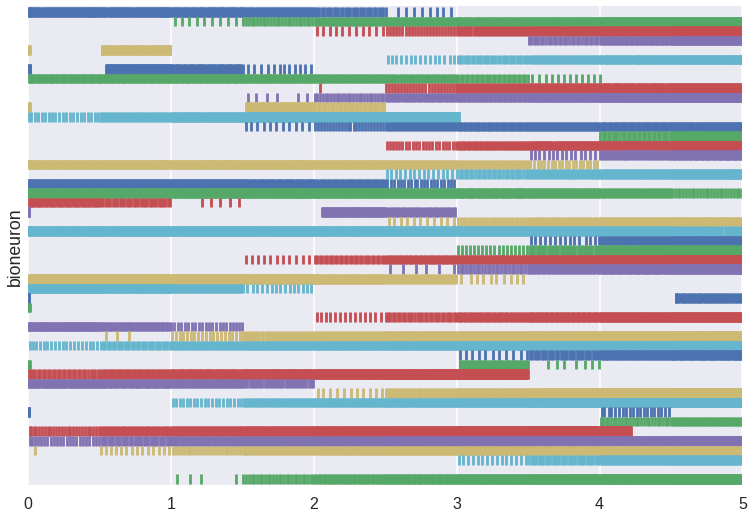

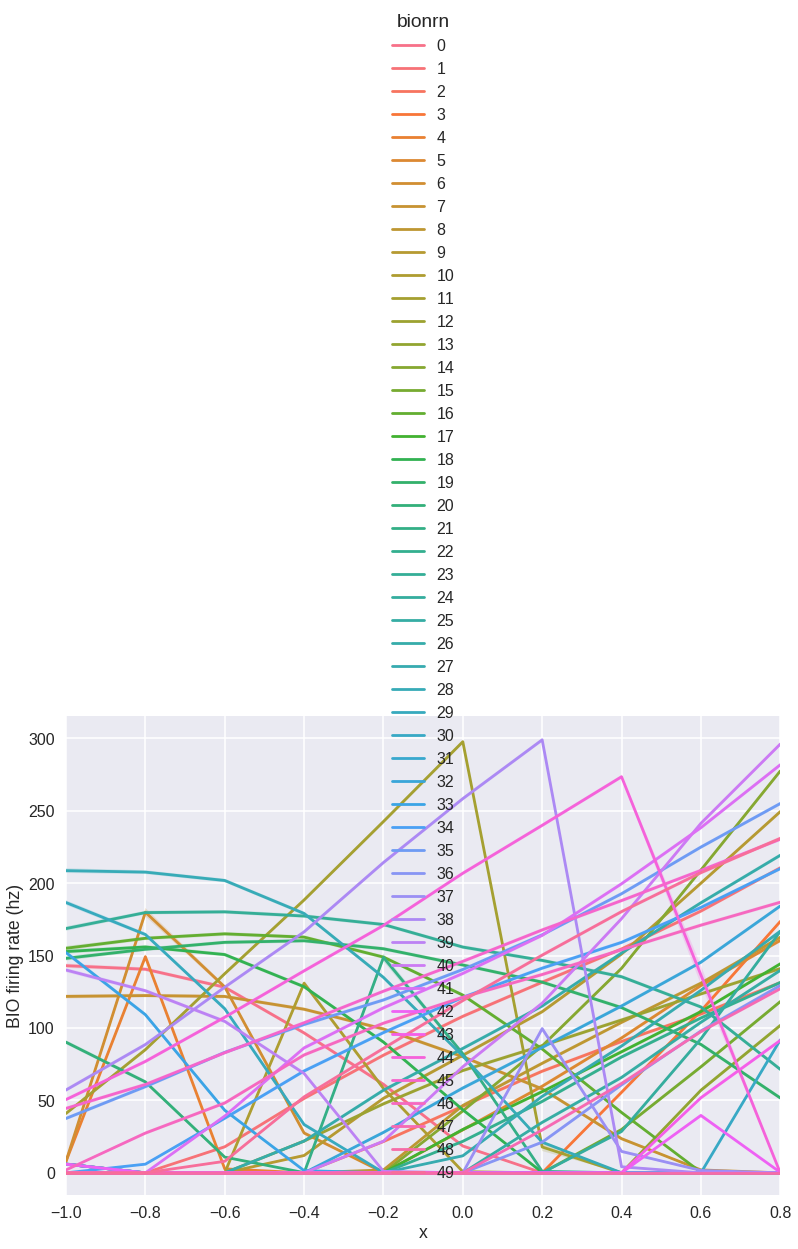

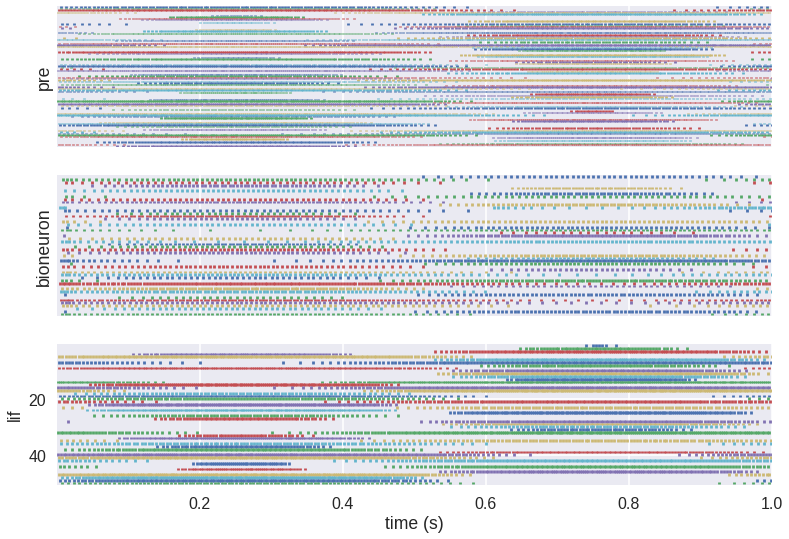

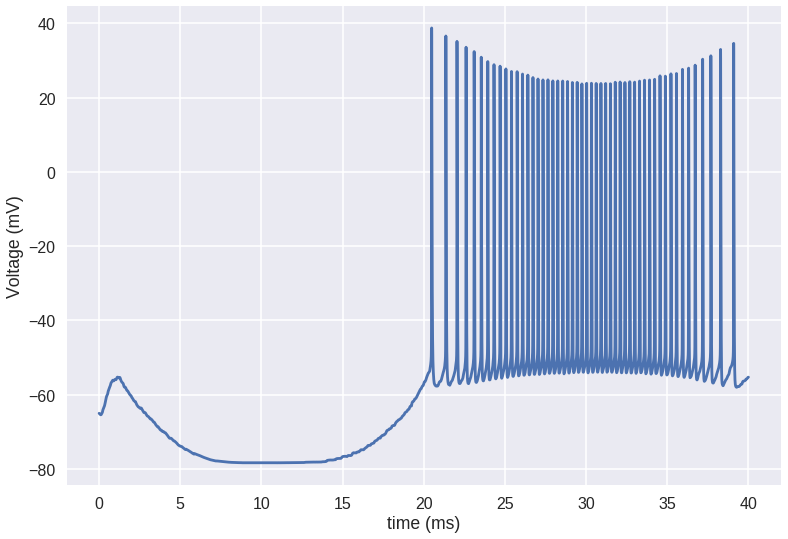

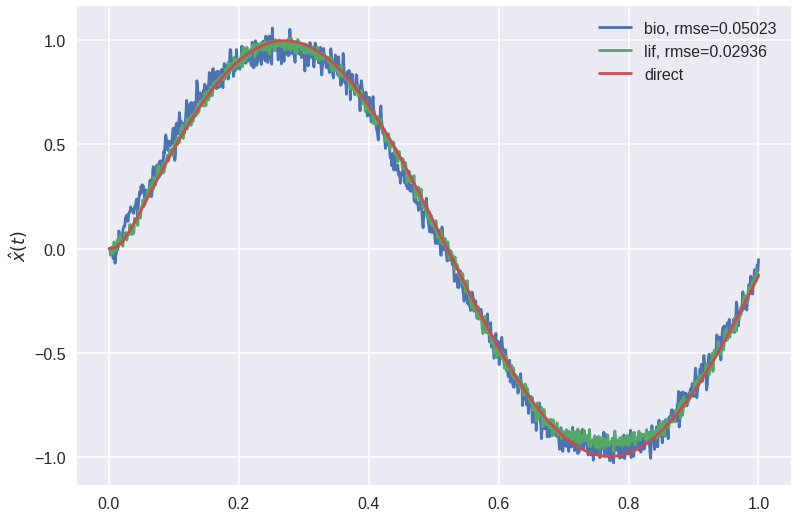

In [163]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=1.0
pre_seed=3
bio_seed=6
delta_rates_threshold=50
rng=np.random.RandomState(seed=333)

dx=0.2
t_per_x=0.5
x_vals=np.arange(-1,1,dx)

lif_encoders, lif_gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)
lif_encoders *= lif_gains.reshape(-1, 1)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

n_unresponsive=2
while n_unresponsive>1:
    delta_rates=response_curve_unit_test(x_vals,t_per_x,n_neurons,tau,dim,n_syn,dt,
                                 lif_encoders,syn_locations,weights_bias,
                                 pre_seed,bio_seed,decoders_bio=None,to_plot='response_curve')
    idx_unresponsive=np.where(delta_rates<delta_rates_threshold)
    n_unresponsive=len(idx_unresponsive)
    print delta_rates, n_unresponsive
    for n in idx_unresponsive:
        new_encoder, new_gain, new_w_bias = pre_model(pre_neurons,1,tau,dim,n_syn,dt,t_final,rng.randint(336699),bio_seed)
        lif_encoders[n] = new_encoder * new_gain.reshape(-1, 1)
        weights_bias[n] = new_w_bias

decoders_bio_6=simulate(n_neurons,tau,dim,n_syn,dt,t_final,lif_encoders,weights_bias,pre_seed,bio_seed)